# CME538 - Introduction to Data Science
**Project 2 - Toronto Bike Share**

**Team: Diligent Debuggers**

**Team members:** 

# Setup Notebook

In [1]:
# Import 3rd party libraries
import os
import json
import time
import numpy as np
import datetime as dt
import codecs
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from io import StringIO
import pytz
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

## Get Station Data
Get the up to date bikeshare station information from `https://tor.publicbikesystem.net`.

In [2]:
response = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
bikeshare_stations = pd.DataFrame(json.loads(response.content)['data']['stations'])[['station_id', 'name', 'lat', 'lon', 'capacity']].astype({'station_id': 'int',})
bikeshare_stations = bikeshare_stations.rename(columns={'station_id': 'Station Id', 
                                                        'name': 'Station Name'})

# View DataFrame
bikeshare_stations.head(15)

,Station Id,Station Name,lat,lon,capacity
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35
1,7001,Wellesley Station Green P,43.664964,-79.383550,26
2,7002,St. George St / Bloor St W,43.667333,-79.399429,19
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,15
4,7004,University Ave / Elm St,43.656518,-79.389099,11
5,7005,King St W / York St,43.648001,-79.383177,19
6,7006,Bay St / College St (East Side),43.660439,-79.385525,19
7,7007,College St / Huron St,43.658148,-79.398167,19
8,7008,Wellesley St / Queen's Park Cres,43.663376,-79.392125,19
9,7009,King St E / Jarvis St,43.650325,-79.372287,25


In [3]:
bikeshare_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station Id    655 non-null    int32  
 1   Station Name  655 non-null    object 
 2   lat           655 non-null    float64
 3   lon           655 non-null    float64
 4   capacity      655 non-null    int64  
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 23.2+ KB


In [4]:
bikeshare_stations.nunique()

Station Id      655
Station Name    655
lat             653
lon             654
capacity         38
dtype: int64

The station dataframe has no missing/duplicated station name or id. 

In [5]:
# Write bikeshare station dataframe to a csv file
path_stations = os.path.join(os.path.abspath(os.getcwd()), 'data', 'stations')
bikeshare_stations.to_csv(os.path.join(path_stations, 'bikeshare_stations.csv'))

## Weather Data

### Load Weather Data

In [6]:
# Set weather data path
path_weather = os.path.join(os.path.abspath(os.getcwd()), 'data', 'weather')

# Get weather file names
weather_filenames = [filename for filename in os.listdir(path_weather) if 'climate' in filename]

# Print file names
print(weather_filenames[0:5])

['en_climate_hourly_ON_6158359_01-2017_P1H.csv', 'en_climate_hourly_ON_6158359_01-2018_P1H.csv', 'en_climate_hourly_ON_6158359_01-2019_P1H.csv', 'en_climate_hourly_ON_6158359_01-2020_P1H.csv', 'en_climate_hourly_ON_6158359_01-2021_P1H.csv']


In [7]:
# Create a dictionary where key:value pairs correspond to the file name and DataFrame respectively
weather_data = {filename: pd.read_csv(os.path.join(path_weather, filename)) for filename in weather_filenames}  

In [8]:
weather_rename = {
    'Date/Time (LST)' : 'Date/Time',
    'Time (LST)' : 'Time',
}

for filename in weather_filenames:
    weather_data[filename].rename(columns=weather_rename, inplace=True)

In [9]:
# Import weather
weather = pd.concat([weather_data[filename] for filename in weather_filenames], ignore_index=True)

# View DataFrame
weather.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),...,Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Precip. Amount (mm),Precip. Amount Flag
0,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 00:00,2017,1,1,00:00,1.5,...,NaN,99.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 01:00,2017,1,1,01:00,1.5,...,NaN,100.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 02:00,2017,1,1,02:00,1.0,...,NaN,100.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 03:00,2017,1,1,03:00,1.2,...,NaN,100.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 04:00,2017,1,1,04:00,1.3,...,NaN,100.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49656 entries, 0 to 49655
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Longitude (x)        49656 non-null  float64
 1   Latitude (y)         49656 non-null  float64
 2   Station Name         49656 non-null  object 
 3   Climate ID           49656 non-null  int64  
 4   Date/Time            49656 non-null  object 
 5   Year                 49656 non-null  int64  
 6   Month                49656 non-null  int64  
 7   Day                  49656 non-null  int64  
 8   Time                 49656 non-null  object 
 9   Temp (°C)            49273 non-null  float64
 10  Temp Flag            331 non-null    object 
 11  Dew Point Temp (°C)  49012 non-null  float64
 12  Dew Point Temp Flag  593 non-null    object 
 13  Rel Hum (%)          49026 non-null  float64
 14  Rel Hum Flag         579 non-null    object 
 15  Wind Dir (10s deg)   46833 non-null 

### Drop Redundant Columns

Apart from the unnecessary columns specified in proposal, 'Stn Press (kPa)' is not important because small atmospheric pressure changes have infinitesimal effects on everyday activities.

In [11]:
weather_clean = weather.drop(['Year', 'Month', 'Day', 'Time', 'Station Name', 'Climate ID', 'Longitude (x)', 'Latitude (y)', 'Stn Press (kPa)'], axis=1)

* The 'Date/Time' column need to be converted to datetime variable and localized to 'EST' timezone.
* The 'Weather' column is the visual observation of the weather environment and appears to be important. The missing values in this column means a clear weather. So missing values should be assigned with 'Clear'.
* There are a number of columns containing the word 'Flag', and only contains NaN or 'M' values. According to Environment and Climate Change Canada, the 'M' represents 'missing' which means the data is unretrievable or unavailable. The flag columns can be removed since they only contain overlapping information.

In [12]:
# Look for and drop the columns containing the word 'Flag'
flag_columns = [col for col in weather.columns if 'Flag' in col]
weather_clean = weather_clean.drop(flag_columns, axis = 1)

In [13]:
weather_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49656 entries, 0 to 49655
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date/Time            49656 non-null  object 
 1   Temp (°C)            49273 non-null  float64
 2   Dew Point Temp (°C)  49012 non-null  float64
 3   Rel Hum (%)          49026 non-null  float64
 4   Wind Dir (10s deg)   46833 non-null  float64
 5   Wind Spd (km/h)      49581 non-null  float64
 6   Visibility (km)      49570 non-null  float64
 7   Hmdx                 8134 non-null   float64
 8   Wind Chill           8862 non-null   float64
 9   Weather              7442 non-null   object 
 10  Precip. Amount (mm)  15318 non-null  float64
dtypes: float64(9), object(2)
memory usage: 4.2+ MB


In [14]:
weather_clean['Wind Chill'].unique()

array([ nan,  -6.,  -2.,  -9., -11., -13., -14., -15., -17., -16., -18.,
       -19., -20., -21., -12., -10.,  -8.,  -7.,  -5.,  -4.,  -3., -22.,
       -26., -24., -23., -25., -28., -29., -31., -30., -27., -32., -33.,
       -35., -34., -36.,  -1.])

In [15]:
weather['Rel Hum (%)'].unique()

array([ 69.,  67.,  68.,  66.,  70.,  63.,  59.,  56.,  54.,  57.,  61.,
        71.,  76.,  74.,  77.,  85.,  83.,  79.,  78.,  84.,  90.,  82.,
        87.,  88.,  72.,  73.,  81.,  92.,  95.,  94.,  96.,  97.,  98.,
        93.,  80.,  65.,  53.,  60.,  64.,  58.,  62.,  49.,  47.,  48.,
        52.,  55.,  75.,  46.,  42.,  89.,  91.,  86.,  99.,  50.,  51.,
       100.,  45.,  43.,  41.,  38.,  36.,  40.,  44.,  32.,  34.,  25.,
        29.,  31.,  33.,  37.,  35.,  26.,  39.,  30.,  nan,  18.,  19.,
        27.,  28.,  20.,  24.,  23.,  17.,  21.,  16.,  22.])

In [16]:
weather['Wind Dir (10s deg)'].unique()

array([26., 27., 23., 24., 25., 22., nan,  3.,  5.,  6.,  8.,  7., 10.,
        9.,  4., 33., 28., 29., 31., 30., 32., 20., 21., 19., 18., 15.,
       14., 12., 13., 16., 17., 34., 35., 11.,  1., 36.,  2.])

### Datetime data

In [17]:
# Convert 'Date/Time' column to datetime variables
est = pytz.timezone('US/Eastern')
utc = pytz.utc

weather_clean['Date/Time'] = weather_clean['Date/Time'].apply(lambda _: est.localize(dt.datetime.strptime(_,'%Y-%m-%d %H:%M')))

In [18]:
weather_clean = weather_clean.set_index('Date/Time')
weather_clean.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather,Precip. Amount (mm)
Date/Time,,,,,,,,,,
2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,NaN,NaN
2017-01-01 01:00:00-05:00,1.5,-3.9,67.0,27.0,35.0,16.1,NaN,NaN,NaN,NaN
2017-01-01 02:00:00-05:00,1.0,-4.3,68.0,26.0,32.0,16.1,NaN,NaN,NaN,NaN
2017-01-01 03:00:00-05:00,1.2,-4.3,67.0,26.0,37.0,16.1,NaN,NaN,NaN,NaN
2017-01-01 04:00:00-05:00,1.3,-4.4,66.0,26.0,28.0,16.1,NaN,NaN,NaN,NaN


### Missing Values

In [19]:
# Check missing values
display(weather_clean.isnull().sum(axis=0).to_frame('count'))

,count
Temp (°C),383
Dew Point Temp (°C),644
Rel Hum (%),630
Wind Dir (10s deg),2823
Wind Spd (km/h),75
Visibility (km),86
Hmdx,41522
Wind Chill,40794
Weather,42214
Precip. Amount (mm),34338


'Hmdx', 'Wind Chill', and 'Weather' columns have significantly more missing values than the other columns.

In [20]:
# Check missing values for each year
display(weather_clean.resample('Y').agg(lambda row: row.isnull().sum()))

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather,Precip. Amount (mm)
Date/Time,,,,,,,,,,
2017-12-31 00:00:00-05:00,11,11,10,530,9,11,7599,7251,7390,8760
2018-12-31 00:00:00-05:00,4,4,2,504,2,4,6979,7084,7336,8760
2019-12-31 00:00:00-05:00,95,145,145,595,23,24,7608,6936,7213,8760
2020-12-31 00:00:00-05:00,13,12,7,426,14,16,7211,7599,7494,8040
2021-12-31 00:00:00-05:00,26,52,47,476,21,16,7307,7383,7624,14
2022-12-31 00:00:00-05:00,234,420,419,292,6,15,4818,4541,5157,4


**Imputing/filling Hmdx and Wind Chill missing values**

According to Environment and Climate Change Canada (https://climate.weather.gc.ca/glossary_e.html), the humidex values are only reported if:

  (1) air temperature is greater than or equal to 20 degrees celsius and,
  
  (2) the humidex value is at least 1 degree greater than the air temperature. 
  
Similarily, wind chill is only calculated if the air temperature is greater than or equal to 0 degrees celsius.

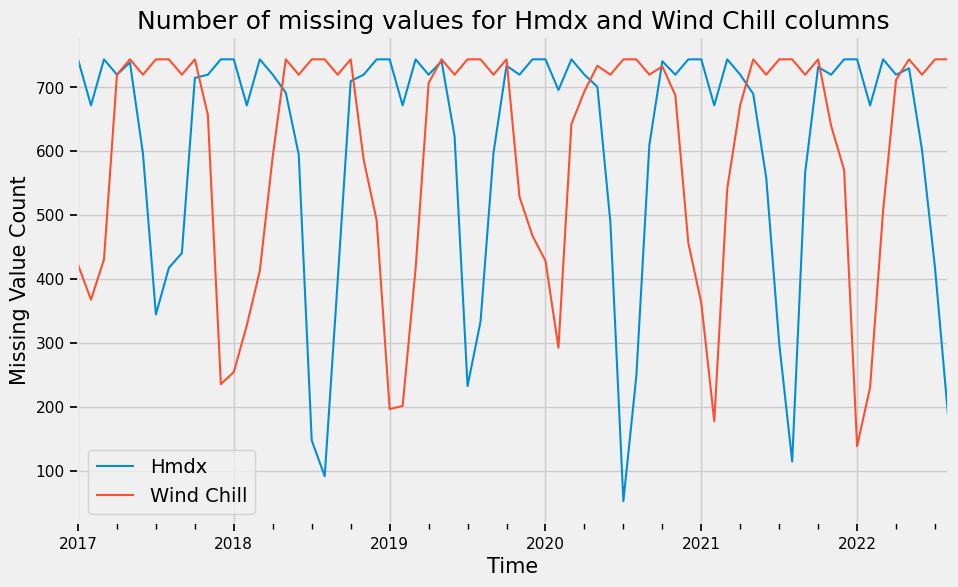

In [21]:
# Visualizing number of missing values in 'Hmdx' and 'Wind Chill' columns
weather_clean.resample('M').agg(lambda row: row.isnull().sum())[['Hmdx', 'Wind Chill']].plot(figsize = (10, 6))

plt.title('Number of missing values for Hmdx and Wind Chill columns', fontsize = 18)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Missing Value Count', fontsize = 15)
plt.legend(['Hmdx', 'Wind Chill'], fontsize = 14)

We can find that there are more missing wind chill values and fewer missing humidex values in the summer, and vice versa in the winter. This agrees with the explanation provided by Environment and Climate Change Canada.

Therefore, the missing values in 'Hmdx' and 'Wind Chill' should not be modified.

**Imputing/filling Weather missing values**

In [22]:
# Modifying missing values in 'Weather' column
weather_clean['Weather'].fillna('Clear', inplace = True)
weather_clean.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather,Precip. Amount (mm)
Date/Time,,,,,,,,,,
2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,NaN
2017-01-01 01:00:00-05:00,1.5,-3.9,67.0,27.0,35.0,16.1,NaN,NaN,Clear,NaN
2017-01-01 02:00:00-05:00,1.0,-4.3,68.0,26.0,32.0,16.1,NaN,NaN,Clear,NaN
2017-01-01 03:00:00-05:00,1.2,-4.3,67.0,26.0,37.0,16.1,NaN,NaN,Clear,NaN
2017-01-01 04:00:00-05:00,1.3,-4.4,66.0,26.0,28.0,16.1,NaN,NaN,Clear,NaN


**Imputing/filling missing values for other columns**

The weather data is sampled every hour, so it should be reasonable to impute missing values based on the time-adjacent valid observations. Except for 'Hmdx', 'Wind Chill', and 'Weather' columns, all other columns will have missing values filled using linear interpolation between valid observations.

In [23]:
# Linear interpolating values 
interpolating_col = weather_clean.columns.drop(['Hmdx', 'Wind Chill', 'Weather'])
weather_clean[interpolating_col] = weather_clean[interpolating_col].interpolate(
    method = 'linear', axis = 0, limit_direction = 'both').round(1)

In [24]:
# Check if there are still missing values
weather_clean.isnull().sum(axis=0).to_frame('count')

,count
Temp (°C),0
Dew Point Temp (°C),0
Rel Hum (%),0
Wind Dir (10s deg),0
Wind Spd (km/h),0
Visibility (km),0
Hmdx,41522
Wind Chill,40794
Weather,0
Precip. Amount (mm),0


In [25]:
weather_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49656 entries, 2017-01-01 00:00:00-05:00 to 2021-12-31 23:00:00-05:00
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temp (°C)            49656 non-null  float64
 1   Dew Point Temp (°C)  49656 non-null  float64
 2   Rel Hum (%)          49656 non-null  float64
 3   Wind Dir (10s deg)   49656 non-null  float64
 4   Wind Spd (km/h)      49656 non-null  float64
 5   Visibility (km)      49656 non-null  float64
 6   Hmdx                 8134 non-null   float64
 7   Wind Chill           8862 non-null   float64
 8   Weather              49656 non-null  object 
 9   Precip. Amount (mm)  49656 non-null  float64
dtypes: float64(9), object(1)
memory usage: 4.2+ MB


### Outliers

check if there are outliers for temperature 

## Bike Share Trip Data

### Load Bike Share Trip Data

In [26]:
# Define the rubbish character in front of the 'trip id' columns in some files
rubbish = ''.join([chr(c) for c in codecs.BOM_UTF8])

def read_bikeshare_csv(path):
    """
    Create a function t"o read bike share trips csv files without the rubbish character.
    """
    with open(path, encoding='utf-8') as f:
        txt = f.read()
        if txt.startswith(rubbish):
            txt = txt[len(rubbish):]
            
        return pd.read_csv(StringIO(txt), encoding='utf-8', encoding_errors='ignore')

In [27]:
# Set bikeshare data path
path_ridership = os.path.join(os.path.abspath(os.getcwd()), 'data', 'ridership')

# Create a list of file names for bike share trips data
trips_filenames = [filename for filename in os.listdir(path_ridership) if 'bike_share' in filename]

# Create a dictionary where key:value pairs correspond to the file name and DataFrame respectively
trips_data = {filename: read_bikeshare_csv(os.path.join(path_ridership, filename)) for filename in trips_filenames}  

In [28]:
# Check the column names of all files
for filename in trips_filenames:
    print(format(trips_data[filename].columns.tolist()))

['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']
['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']
['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']
['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']
['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']
['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']
['trip_id', 'trip_star

In [29]:
# Rename the columns in 2017 and 2018 data
trips_rename = {
    'trip_id' : 'Trip Id',
    'trip_start_time' : 'Start Time',
    'trip_stop_time' : 'End Time',
    'trip_duration_seconds' : 'Trip Duration',
    'from_station_id' : 'Start Station Id',
    'from_station_name' : 'Start Station Name',
    'to_station_id' : 'End Station Id',
    'to_station_name' : 'End Station Name',
    'user_type' : 'User Type'
}

for filename in trips_filenames:
    if ('2017' in filename) or ('2018' in filename):
        trips_data[filename].rename(columns=trips_rename, inplace=True)
    else:
        trips_data[filename].rename(columns={'Trip  Duration' : 'Trip Duration'}, inplace=True)

In [30]:
# Concatenate the ridership data into one dataframe 
ridership = pd.concat([trips_data[filename] for filename in trips_filenames], ignore_index=True)

# View DataFrame
ridership.head()

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type,Subscription Id,Bike Id
0,712441,2017-01-01 05:03 (UTC),2017-01-01 05:08 (UTC),274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member,NaN,NaN
1,712442,2017-01-01 05:03 (UTC),2017-01-01 05:12 (UTC),538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member,NaN,NaN
2,712443,2017-01-01 05:05 (UTC),2017-01-01 05:22 (UTC),992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member,NaN,NaN
3,712444,2017-01-01 05:09 (UTC),2017-01-01 05:26 (UTC),1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member,NaN,NaN
4,712445,2017-01-01 05:14 (UTC),2017-01-01 05:25 (UTC),645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member,NaN,NaN


In [31]:
ridership.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15358993 entries, 0 to 15358992
Data columns (total 11 columns):
 #   Column              Non-Null Count     Dtype  
---  ------              --------------     -----  
 0   Trip Id             15358993 non-null  int64  
 1   Start Time          15358993 non-null  object 
 2   End Time            15358992 non-null  object 
 3   Trip Duration       15358993 non-null  int64  
 4   Start Station Id    14332100 non-null  float64
 5   Start Station Name  15262057 non-null  object 
 6   End Station Id      14327681 non-null  float64
 7   End Station Name    15256259 non-null  object 
 8   User Type           15358993 non-null  object 
 9   Subscription Id     5052221 non-null   float64
 10  Bike Id             11943393 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 1.3+ GB


In [32]:
ridership['User Type'].unique()

array(['Member', 'Casual', 'Annual Member', 'Casual Member'], dtype=object)

Problems in the dataset:
* There are a lot of null values.
* Start Time and End Time values need to be first converted into datatime variables with timezone info and then converted to 'US/Eastern' timezone.
* User Types need to be unified.

### Drop Redundant Columns

In [33]:
#Drop Bike ID and Subscription ID columns
ridership.drop(['Subscription Id', 'Bike Id'], axis=1, inplace=True)

In [34]:
user_rename = {
    'Annual Member' : 'Member',
    'Casual Member' : 'Casual'
}

ridership.rename(columns=user_rename, inplace=True)

In [35]:
ridership.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15358993 entries, 0 to 15358992
Data columns (total 9 columns):
 #   Column              Non-Null Count     Dtype  
---  ------              --------------     -----  
 0   Trip Id             15358993 non-null  int64  
 1   Start Time          15358993 non-null  object 
 2   End Time            15358992 non-null  object 
 3   Trip Duration       15358993 non-null  int64  
 4   Start Station Id    14332100 non-null  float64
 5   Start Station Name  15262057 non-null  object 
 6   End Station Id      14327681 non-null  float64
 7   End Station Name    15256259 non-null  object 
 8   User Type           15358993 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 1.0+ GB


In [36]:
#Set Trip ID to index
ridership.set_index('Trip Id')

,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
Trip Id,,,,,,,,
712441,2017-01-01 05:03 (UTC),2017-01-01 05:08 (UTC),274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member
712442,2017-01-01 05:03 (UTC),2017-01-01 05:12 (UTC),538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member
712443,2017-01-01 05:05 (UTC),2017-01-01 05:22 (UTC),992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member
712444,2017-01-01 05:09 (UTC),2017-01-01 05:26 (UTC),1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member
712445,2017-01-01 05:14 (UTC),2017-01-01 05:25 (UTC),645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member
...,...,...,...,...,...,...,...,...
18317445,31/08/2022 23:58:00 (EST),01/09/2022 00:26:00 (EST),1670,7100.0,Dundas St E / Regent Park Blvd,7322.0,King St W / Brant St,Casual Member
18317447,31/08/2022 23:58:00 (EST),01/09/2022 00:08:00 (EST),574,7245.0,Tecumseth St / Queen St W - SMART,7069.0,Queen St W / Spadina Ave,Annual Member
18317448,31/08/2022 23:59:00 (EST),01/09/2022 00:08:00 (EST),533,7257.0,Dundas St W / St. Patrick St,7037.0,Bathurst St / Dundas St W,Casual Member


In [37]:
ridership[ridership['End Time'].isnull()==True]

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
337055,2302635,2017-11-29 10:53 (UTC),NaN,0,NaN,Seaton St / Dundas St E,NaN,NaN,Casual


In [38]:
#Drop the row with null End Time
ridership = ridership[ridership['End Time'].isnull()==False]

### Split ridership data for different years 

In [100]:
# Separate ridership data according to year
ridership_2017 = ridership.loc[ridership['Start Time'].str.contains('2017')]
ridership_2018 = ridership.loc[ridership['Start Time'].str.contains('2018')]
ridership_2019 = ridership.loc[ridership['Start Time'].str.contains('2019')]
ridership_2020 = ridership.loc[ridership['Start Time'].str.contains('2020')]
ridership_2021 = ridership.loc[ridership['Start Time'].str.contains('2021')]
ridership_2022 = ridership.loc[ridership['Start Time'].str.contains('2022')]

### Datetime data

In [101]:
def time_convert(df):
    """Convert Start Time and End Time into datetime variables"""
    df_utc = df.loc[df['Start Time'].str.contains('UTC')]
    df_est = df.loc[df['Start Time'].str.contains('EST')]
    
    df_utc['Start Time'] = df_utc['Start Time'].apply(lambda _: utc.localize(dt.datetime.strptime(_,'%Y-%m-%d %H:%M (%Z)')).astimezone(est))  
    df_est['Start Time'] = df_est['Start Time'].apply(lambda _: est.localize(dt.datetime.strptime(_,'%d/%m/%Y %H:%M:%S (EST)')))
    df_utc['End Time'] = df_utc['End Time'].apply(lambda _: utc.localize(dt.datetime.strptime(_,'%Y-%m-%d %H:%M (%Z)')).astimezone(est))   
    df_est['End Time'] = df_est['End Time'].apply(lambda _: est.localize(dt.datetime.strptime(_,'%d/%m/%Y %H:%M:%S (EST)')))
    
    df = pd.concat([df_utc, df_est])
    
    return df

In [43]:
# Make a copy of the dataframe with converted datetime value in case we need to do the conversion again
ridership_est_copy = ridership_est.copy()
ridership_est_copy.to_csv('ridership_est.csv') # This step takes about 4 min in my computer and is optional if you don't want to export the data to save runtime.

### Missing Values

ridership_est dataframe is separated into smaller dataframes according to year for better analyzing.

In [46]:
def remove_outliers(data):
    """
    Create a function to remove the duration outliers in the dataset
    """
    # Narrow down our dataset with 60 seconds duration filter
    data_copy = data.copy()
    data =data[data['Trip Duration']>=60]
    
    # Compute quartiles
    Q1 =data ['Trip Duration'].quantile(0.25)
    Q3 =data ['Trip Duration'].quantile(0.75)
    IQR = Q3 - Q1
    data  = data[(data['Trip Duration']<=(Q3+1.5*IQR)) & (data['Trip Duration']>=(Q1-1.5*IQR))]
    print("Percent of outliers removed: {}%".format((1-len(data) / len(data_copy)) * 100))
    return data

#### **2017 Data**

In [102]:
ridership_est_2017 = time_convert(ridership_2017)

In [47]:
# Remove trip duration outliers
ridership_est_2017 = remove_outliers(ridership_est_2017)

Percent of outliers removed: 7.6552458939496475%


In [48]:
ridership_est_2017.isnull().sum()

Trip Id                    0
Start Time                 0
End Time                   0
Trip Duration              0
Start Station Id      934259
Start Station Name         0
End Station Id        934259
End Station Name           0
User Type                  0
dtype: int64

The missing Station Id can be imputed using the Station Data

In [49]:
#The trips with missing Station Id
ridership_est_2017[
    (ridership_est_2017['Start Station Id'].isnull()==True) | 
    (ridership_est_2017['End Station Id'].isnull()==True)].head()

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
41417,1971685,2017-10-01 01:00:00-04:00,2017-10-01 01:14:00-04:00,849,NaN,Queen St W / James St,NaN,Taddle Creek Park,Member
41419,1971687,2017-10-01 01:00:00-04:00,2017-10-01 01:22:00-04:00,1310,NaN,Hayter St / Laplante Ave,NaN,Queen St W / Portland St,Member
41420,1971688,2017-10-01 01:00:00-04:00,2017-10-01 01:11:00-04:00,631,NaN,Beverly St / College St,NaN,Beverly St / Dundas St W,Member
41421,1971689,2017-10-01 01:00:00-04:00,2017-10-01 01:20:00-04:00,1198,NaN,Thompson St / Broadview Ave - SMART,NaN,Thompson St / Broadview Ave - SMART,Member
41422,1971690,2017-10-01 01:01:00-04:00,2017-10-01 01:07:00-04:00,396,NaN,Dundonald St / Church St,NaN,Victoria St / Gould St (Ryerson University),Member


We will use station data as a reference to fill missing Start or End Station Id values.

In [50]:
# Create a function for filling missing station ID according to station name
def fill_ID(df):
    """This function is for filling missing station names according to station ID
    """
    df['Start Station Id'].fillna(
        df['Start Station Name'].map(bikeshare_stations.set_index('Station Name')['Station Id']),
        inplace=True)
    
    df['End Station Id'].fillna(
        df['End Station Name'].map(bikeshare_stations.set_index('Station Name')['Station Id']),
        inplace=True)
    
    return df

In [51]:
# Create a function for filling missing station name according to station ID
def fill_name(df):
    """This function is for filling missing station names according to station ID
    """
    df['Start Station Name'].fillna(
        df['Start Station Id'].map(bikeshare_stations.set_index('Station Id')['Station Name']),
        inplace=True)
    
    df['End Station Name'].fillna(
        df['End Station Id'].map(bikeshare_stations.set_index('Station Id')['Station Name']),
        inplace=True)
    
    return df

In [52]:
fill_ID(ridership_est_2017)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:22:00-05:00,992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:26:00-05:00,1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:25:00-05:00,645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member
...,...,...,...,...,...,...,...,...,...
1492364,1971680,2017-10-01 00:59:00-04:00,2017-10-01 01:04:00-04:00,337,7031.0,Jarvis St / Isabella St,7126.0,Yonge St / Yorkville Ave,Member
1492365,1971681,2017-10-01 00:59:00-04:00,2017-10-01 01:07:00-04:00,494,7024.0,Dundonald St / Church St,NaN,Victoria St / Gould St (Ryerson University),Member
1492366,1971682,2017-10-01 00:59:00-04:00,2017-10-01 01:18:00-04:00,1114,7248.0,Baldwin Ave / Spadina Ave - SMART,7135.0,Hanna Ave / Liberty St,Member
1492367,1971683,2017-10-01 00:59:00-04:00,2017-10-01 01:19:00-04:00,1192,7043.0,Queens Quay W / Lower Simcoe St,7243.0,Exhibition GO Station,Casual


In [53]:
fill_name(ridership_est_2017)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:22:00-05:00,992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:26:00-05:00,1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:25:00-05:00,645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member
...,...,...,...,...,...,...,...,...,...
1492364,1971680,2017-10-01 00:59:00-04:00,2017-10-01 01:04:00-04:00,337,7031.0,Jarvis St / Isabella St,7126.0,Yonge St / Yorkville Ave,Member
1492365,1971681,2017-10-01 00:59:00-04:00,2017-10-01 01:07:00-04:00,494,7024.0,Dundonald St / Church St,NaN,Victoria St / Gould St (Ryerson University),Member
1492366,1971682,2017-10-01 00:59:00-04:00,2017-10-01 01:18:00-04:00,1114,7248.0,Baldwin Ave / Spadina Ave - SMART,7135.0,Hanna Ave / Liberty St,Member
1492367,1971683,2017-10-01 00:59:00-04:00,2017-10-01 01:19:00-04:00,1192,7043.0,Queens Quay W / Lower Simcoe St,7243.0,Exhibition GO Station,Casual


In [54]:
ridership_est_2017.isnull().sum()

Trip Id                    0
Start Time                 0
End Time                   0
Trip Duration              0
Start Station Id      236899
Start Station Name         0
End Station Id        241763
End Station Name           0
User Type                  0
dtype: int64

In [55]:
#Check again the trips with missing Station Id
ridership_est_2017[
    (ridership_est_2017['Start Station Id'].isnull()==True) | 
    (ridership_est_2017['End Station Id'].isnull()==True)].head()

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
41419,1971687,2017-10-01 01:00:00-04:00,2017-10-01 01:22:00-04:00,1310,7162.0,Hayter St / Laplante Ave,NaN,Queen St W / Portland St,Member
41420,1971688,2017-10-01 01:00:00-04:00,2017-10-01 01:11:00-04:00,631,NaN,Beverly St / College St,NaN,Beverly St / Dundas St W,Member
41422,1971690,2017-10-01 01:01:00-04:00,2017-10-01 01:07:00-04:00,396,7024.0,Dundonald St / Church St,NaN,Victoria St / Gould St (Ryerson University),Member
41423,1971691,2017-10-01 01:01:00-04:00,2017-10-01 01:11:00-04:00,592,NaN,Widmer St / Adelaide St W,7033.0,Union Station,Casual
41424,1971692,2017-10-01 01:01:00-04:00,2017-10-01 01:14:00-04:00,810,NaN,Stewart St / Bathurst St - SMART,7022.0,Simcoe St / Queen St W,Casual


The remaining missing values are because there are inconsistency issues with the station name column. So we need to update the Station Names.

In [56]:
# Obtain an updated station name list from station dataset
station_names = bikeshare_stations['Station Name'].unique()

In [111]:
# Create a function for updating the station names using fuzz
# we use token sort ratio from fuzz to match two similar strings as possible pairs
# of old and new station names. If the order in which the words are placed in 
# a particular sentence doesn’t matter then the best way to match two strings 
# is by the use of Token Sort Ratio.

def name_fuzz(old_name, station_names):
    """This function creates a dictionary to update an old_name 
    with a new name (the station names in the bikeshare_station dataset).
    """
    result_dict  = {0: 'No Match Station'}
    
    if old_name in station_names:
        return old_name
    else:
        for new_name in station_names:
            if fuzz.token_sort_ratio(new_name,old_name) >= 80:
                result_dict[fuzz.token_sort_ratio(new_name,old_name)] = str(new_name)
    
    result = result_dict[max(result_dict.keys())]
    
    return result

In [57]:
# Create a function for replacing the name
def name_replace(old_name):
    """This function is to replace the old station name in a dataframe. 
    """
    
    if old_name in stations_old['Station Name']:
        return stations_old[stations_old['Station Name'] == old_name]['New Name'].tolist()[0]
    else:
        return old_name

In [58]:
# Extracting both starting names and ending names from the ridership dataframe as old station names
stations_start = ridership_est[['Start Station Id', 'Start Station Name']]
stations_end = ridership_est[['End Station Id', 'End Station Name']]
stations_start.columns = stations_end.columns = ['Station Id', 'Station Name']

In [75]:
# Combine the stations in to a single dataframe
stations_old = pd.concat([stations_start, stations_end]).dropna(how='all').drop_duplicates().reset_index(drop=True)

stations_old['Station Name'].nunique()

817

In [85]:
stations_old_ID = stations_old.sort_values('Station Id').dropna()
stations_old_noID = stations_old[stations_old['Station Id'].isnull()==True]
stations_old_noID

,Station Id,Station Name
200,NaN,Queen St W / James St
201,NaN,Stewart St / Bathurst St - SMART
202,NaN,Hayter St / Laplante Ave
203,NaN,Beverly St / College St
204,NaN,Thompson St / Broadview Ave - SMART
...,...,...
466,NaN,Victoria Park Subway Station - SMART
467,NaN,Dundas St W / Roncesvalles Green P - SMART
468,NaN,Dufferin Gate - SMART
469,NaN,Church St / Wood St


In [86]:
# try finding the stations with missing ID 
stations_old_noID['Station Id'].fillna(
    stations_old_noID['Station Name'].map(bikeshare_stations.set_index('Station Name')['Station Id']),
    inplace=True)

In [87]:
stations_old_noID

,Station Id,Station Name
200,7275.0,Queen St W / James St
201,NaN,Stewart St / Bathurst St - SMART
202,7162.0,Hayter St / Laplante Ave
203,NaN,Beverly St / College St
204,7236.0,Thompson St / Broadview Ave - SMART
...,...,...
466,7266.0,Victoria Park Subway Station - SMART
467,7229.0,Dundas St W / Roncesvalles Green P - SMART
468,7244.0,Dufferin Gate - SMART
469,7089.0,Church St / Wood St


In [94]:
stations_old = pd.concat([stations_old_ID, stations_old_noID])

In [112]:
find_fuzzname = stations_old[stations_old['Station Id'].isnull()==True]
find_fuzzname['possible_new_name'] = find_fuzzname['Station Name'].apply(lambda row: name_fuzz(row, station_names))
find_fuzzname

,Station Id,Station Name,possible_new_name
201,NaN,Stewart St / Bathurst St - SMART,No Match Station
203,NaN,Beverly St / College St,Beverley St / College St
206,NaN,Widmer St / Adelaide St W,No Match Station
208,NaN,University Ave / College St,University Ave / College St (East)
214,NaN,Queen St W / Portland St,Queen St W / John St
218,NaN,Dovercourt Rd / Harrison St - SMART,Dovercourt Rd / Harrison St (Green P) - SMART
220,NaN,Bloor St / Brunswick Ave,Bloor St W / Brock Ave
226,NaN,Roxton Rd / College St,No Match Station
228,NaN,University Ave / King St W,University Ave / King St W - SMART
236,NaN,Dockside Dr / Queens Quay E (Sugar Beach),No Match Station


In [110]:
find_fuzzname.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 201 to 470
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Station Id         0 non-null      float64
 1   Station Name       56 non-null     object 
 2   possible_new_name  56 non-null     object 
dtypes: float64(1), object(2)
memory usage: 1.8+ KB


In [92]:
# Drop rows with missing Id
stations_old = stations_old.sort_values('Station Id').dropna()
stations_old['Station Name'].nunique()

807

In [60]:
# Merge the stations_old with bikeshare_stations to relate all station names 
# with the most updated names using their Id
stations_merge = pd.merge(stations_old, 
                          bikeshare_stations, 
                          on='Station Id', 
                          how='left',
                          suffixes=('_messy', '_new'))

stations_merge = stations_merge.drop_duplicates(subset='Station Name_messy')

In [61]:
is_null = stations_merge['Station Name_new'].isnull()
stations_merge[is_null]

,Station Id,Station Name_messy,Station Name_new,lat,lon,capacity
16,7011.0,Wellington St W / Portland St,NaN,NaN,NaN,NaN
18,7013.0,Scott St / The Esplanade,NaN,NaN,NaN,NaN
22,7017.0,Widmer St / Adelaide St,NaN,NaN,NaN,NaN
23,7017.0,Widmer St / Adelaide St W,NaN,NaN,NaN,NaN
25,7019.0,Temperance St / Yonge St,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
762,7638.0,Warehouse EBS-Station,NaN,NaN,NaN,NaN
777,7649.0,Greenwood Subway Station,NaN,NaN,NaN,NaN
778,7649.0,Greenwood Subway Station - SMART,NaN,NaN,NaN,NaN
780,7651.0,Bloor St W / Gladstone Ave,NaN,NaN,NaN,NaN


These stations don't have a new station name, meaning that they are canceled now. So we add a suffix "_canceled" to its name to be the new station name.

In [62]:
stations_merge['Station Name_new'].fillna(
        stations_merge['Station Name_messy']+'_canceled',
        inplace=True)

In [63]:
stations_merge[is_null]

,Station Id,Station Name_messy,Station Name_new,lat,lon,capacity
16,7011.0,Wellington St W / Portland St,Wellington St W / Portland St_canceled,NaN,NaN,NaN
18,7013.0,Scott St / The Esplanade,Scott St / The Esplanade_canceled,NaN,NaN,NaN
22,7017.0,Widmer St / Adelaide St,Widmer St / Adelaide St _canceled,NaN,NaN,NaN
23,7017.0,Widmer St / Adelaide St W,Widmer St / Adelaide St W_canceled,NaN,NaN,NaN
25,7019.0,Temperance St / Yonge St,Temperance St / Yonge St_canceled,NaN,NaN,NaN
...,...,...,...,...,...,...
762,7638.0,Warehouse EBS-Station,Warehouse EBS-Station_canceled,NaN,NaN,NaN
777,7649.0,Greenwood Subway Station,Greenwood Subway Station_canceled,NaN,NaN,NaN
778,7649.0,Greenwood Subway Station - SMART,Greenwood Subway Station - SMART_canceled,NaN,NaN,NaN
780,7651.0,Bloor St W / Gladstone Ave,Bloor St W / Gladstone Ave_canceled,NaN,NaN,NaN


All the canceled station names are renamed!

In [64]:
stations_merge.head(10)

,Station Id,Station Name_messy,Station Name_new,lat,lon,capacity
0,7000.0,Fort York Blvd / Capreol Crt,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35.0
1,7000.0,Fort York Blvd / Capreol Ct,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35.0
2,7001.0,Wellesley Station Green P,Wellesley Station Green P,43.664964,-79.383550,26.0
3,7001.0,Lower Jarvis St / The Esplanade,Wellesley Station Green P,43.664964,-79.383550,26.0
4,7002.0,St George St / Bloor St W,St. George St / Bloor St W,43.667333,-79.399429,19.0
5,7002.0,St. George St / Bloor St W,St. George St / Bloor St W,43.667333,-79.399429,19.0
6,7003.0,Madison Ave / Bloor St W,Madison Ave / Bloor St W,43.667158,-79.402761,15.0
7,7004.0,University Ave / Elm St,University Ave / Elm St,43.656518,-79.389099,11.0
8,7005.0,University Ave / King St W,King St W / York St,43.648001,-79.383177,19.0
9,7005.0,King St W / York St,King St W / York St,43.648001,-79.383177,19.0


Now we can update names in ridership dataframe using stations_merge.

In [65]:
def update_name(old_name):
    """This function is to update the Station Name with the most updated name 
    (the station names in the bikeshare_station dataset) according to their 
    relating station Id.
    """
    if old_name in stations_merge['Station Name_messy']:
        return stations_merge[stations_merge['Station Name_messy']==old_name]['Station Name_new'].tolist()[0]
    else:
        return old_name    

In [66]:
def replace_name(df):
    """Replaces the Start Station Name and End Station Name using update_name
    """
    
    df['Start Station Name'] = df['Start Station Name'].apply(lambda row: update_name(row))
    df['End Station Name'] = df['End Station Name'].apply(lambda row: update_name(row))
    
    return df 

In [67]:
copy_2017 = ridership_est_2017.copy()

In [68]:
replace_name(ridership_est_2017)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:22:00-05:00,992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:26:00-05:00,1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:25:00-05:00,645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member
...,...,...,...,...,...,...,...,...,...
1492364,1971680,2017-10-01 00:59:00-04:00,2017-10-01 01:04:00-04:00,337,7031.0,Jarvis St / Isabella St,7126.0,Yonge St / Yorkville Ave,Member
1492365,1971681,2017-10-01 00:59:00-04:00,2017-10-01 01:07:00-04:00,494,7024.0,Dundonald St / Church St,NaN,Victoria St / Gould St (Ryerson University),Member
1492366,1971682,2017-10-01 00:59:00-04:00,2017-10-01 01:18:00-04:00,1114,7248.0,Baldwin Ave / Spadina Ave - SMART,7135.0,Hanna Ave / Liberty St,Member
1492367,1971683,2017-10-01 00:59:00-04:00,2017-10-01 01:19:00-04:00,1192,7043.0,Queens Quay W / Lower Simcoe St,7243.0,Exhibition GO Station,Casual


In [69]:
# fill missing ID with new station names
fill_ID(ridership_est_2017)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:22:00-05:00,992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:26:00-05:00,1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:25:00-05:00,645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member
...,...,...,...,...,...,...,...,...,...
1492364,1971680,2017-10-01 00:59:00-04:00,2017-10-01 01:04:00-04:00,337,7031.0,Jarvis St / Isabella St,7126.0,Yonge St / Yorkville Ave,Member
1492365,1971681,2017-10-01 00:59:00-04:00,2017-10-01 01:07:00-04:00,494,7024.0,Dundonald St / Church St,NaN,Victoria St / Gould St (Ryerson University),Member
1492366,1971682,2017-10-01 00:59:00-04:00,2017-10-01 01:18:00-04:00,1114,7248.0,Baldwin Ave / Spadina Ave - SMART,7135.0,Hanna Ave / Liberty St,Member
1492367,1971683,2017-10-01 00:59:00-04:00,2017-10-01 01:19:00-04:00,1192,7043.0,Queens Quay W / Lower Simcoe St,7243.0,Exhibition GO Station,Casual


In [70]:
#Check again the trips with missing Station Id
ridership_est_2017[
    (ridership_est_2017['Start Station Id'].isnull()==True) | 
    (ridership_est_2017['End Station Id'].isnull()==True)].head()

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
41419,1971687,2017-10-01 01:00:00-04:00,2017-10-01 01:22:00-04:00,1310,7162.0,Hayter St / Laplante Ave,NaN,Queen St W / Portland St,Member
41420,1971688,2017-10-01 01:00:00-04:00,2017-10-01 01:11:00-04:00,631,NaN,Beverly St / College St,NaN,Beverly St / Dundas St W,Member
41422,1971690,2017-10-01 01:01:00-04:00,2017-10-01 01:07:00-04:00,396,7024.0,Dundonald St / Church St,NaN,Victoria St / Gould St (Ryerson University),Member
41423,1971691,2017-10-01 01:01:00-04:00,2017-10-01 01:11:00-04:00,592,NaN,Widmer St / Adelaide St W,7033.0,Union Station,Casual
41424,1971692,2017-10-01 01:01:00-04:00,2017-10-01 01:14:00-04:00,810,NaN,Stewart St / Bathurst St - SMART,7022.0,Simcoe St / Queen St W,Casual


In [71]:
ridership_est_2017.isnull().sum()

Trip Id                    0
Start Time                 0
End Time                   0
Trip Duration              0
Start Station Id      236899
Start Station Name         0
End Station Id        241763
End Station Name           0
User Type                  0
dtype: int64

#### **2018 Data**

In [103]:
ridership_est_2018 = time_convert(ridership_2018)

In [108]:
ridership_est_2018 = remove_outliers(ridership_est_2018)

Percent of outliers removed: 5.0232325937559335%


In [109]:
ridership_est_2018.isnull().sum()

Trip Id                0
Start Time             0
End Time               0
Trip Duration          0
Start Station Id      54
Start Station Name     0
End Station Id        54
End Station Name       0
User Type              0
dtype: int64

The station names may need cleaning

In [114]:
replace_name(ridership_est_2018)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
404824,2383591,2017-12-31 19:00:00-05:00,2017-12-31 19:05:00-05:00,320,NaN,Charles St E / Jarvis St - SMART,NaN,Bay St / St. Joseph St,Member
404825,2383592,2017-12-31 19:04:00-05:00,2017-12-31 19:09:00-05:00,294,NaN,McGill St / Church St,NaN,University Ave / Gerrard St W,Member
404826,2383593,2017-12-31 19:07:00-05:00,2017-12-31 19:12:00-05:00,338,NaN,Church St / Wood St,NaN,Sherbourne St / Wellesley St E,Member
404827,2383594,2017-12-31 19:11:00-05:00,2017-12-31 19:17:00-05:00,337,NaN,St. George St / Russell St - SMART,NaN,Hayter St / Laplante Ave,Member
404828,2383595,2017-12-31 19:16:00-05:00,2017-12-31 19:23:00-05:00,406,NaN,Bathurst St / Queens Quay W,NaN,Bremner Blvd / Spadina Ave,Member
...,...,...,...,...,...,...,...,...,...
3415319,4158587,2018-10-01 00:47:00-04:00,2018-10-01 01:16:00-04:00,1724,7195.0,Ulster St / Bathurst St,7195.0,Ulster St / Bathurst St,Annual Member
3415320,4158588,2018-10-01 00:49:00-04:00,2018-10-01 01:16:00-04:00,1632,7195.0,Ulster St / Bathurst St,7195.0,Ulster St / Bathurst St,Annual Member
3415321,4158589,2018-10-01 00:53:00-04:00,2018-10-01 00:55:00-04:00,162,7121.0,Jarvis St / Dundas St E,7038.0,Dundas St W / Yonge St,Annual Member
3415322,4158590,2018-10-01 00:53:00-04:00,2018-10-01 01:01:00-04:00,474,7140.0,Macpherson Ave / Spadina Rd,7281.0,Charles St W / Balmuto St - SMART,Annual Member


#### **2019 Data**

In [115]:
ridership_est_2019 = time_convert(ridership_2019)

In [116]:
ridership_est_2019 = remove_outliers(ridership_est_2019)

Percent of outliers removed: 4.5134762785279285%


In [117]:
ridership_est_2019.isnull().sum()

Trip Id                 0
Start Time              0
End Time                0
Trip Duration           0
Start Station Id        0
Start Station Name      0
End Station Id        392
End Station Name      392
User Type               0
dtype: int64

In [118]:
print("Percent of information loss for drop missing values: {}".format(392 /len(ridership_est_2019) * 100))

Percent of information loss for drop missing values: 0.016827840460052552


In [119]:
# Examine the rows with missing station Id and station name
ridership_est_2019[
    (ridership_est_2019['End Station Name'].isnull()==True) | 
    (ridership_est_2019['End Station Id'].isnull()==True)]

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
3476980,6795174,2019-10-01 06:07:00-04:00,2019-10-01 06:35:00-04:00,1676,7425.0,The Queensway at South Kingsway - SMART,NaN,NaN,Annual Member
3478120,6796528,2019-10-01 08:20:00-04:00,2019-10-01 08:31:00-04:00,674,7070.0,25 York St – Union Station South,NaN,NaN,Annual Member
3478429,6796906,2019-10-01 08:34:00-04:00,2019-10-01 08:48:00-04:00,840,7347.0,Regal Rd / Dufferin St,NaN,NaN,Annual Member
3480163,6799037,2019-10-01 10:07:00-04:00,2019-10-01 10:19:00-04:00,713,7317.0,Hubbard Blvd / Balsam Av,NaN,NaN,Annual Member
3482184,6801398,2019-10-01 14:33:00-04:00,2019-10-01 15:00:00-04:00,1627,7299.0,Mill St / Parliament St,NaN,NaN,Annual Member
...,...,...,...,...,...,...,...,...,...
5834744,6772378,2019-09-28 18:24:00-04:00,2019-09-28 18:50:00-04:00,1554,7038.0,Dundas St W / Yonge St,NaN,NaN,Annual Member
5845945,6785059,2019-09-30 08:41:00-04:00,2019-09-30 08:59:00-04:00,1100,7438.0,High Park Subway - SMART,NaN,NaN,Annual Member
5850402,6790168,2019-09-30 16:53:00-04:00,2019-09-30 17:06:00-04:00,807,7011.0,Wellington St W / Portland St,NaN,NaN,Annual Member
5851848,6791678,2019-09-30 17:50:00-04:00,2019-09-30 18:20:00-04:00,1808,7016.0,Bay St / Queens Quay W (Ferry Terminal),NaN,NaN,Annual Member


It's clear that these rows should be dropped, and they only cause around 0.017% of information loss.

In [120]:
ridership_est_2019 = ridership_est_2019[
    (ridership_est_2019['End Station Name'].isnull()==False) | 
    (ridership_est_2019['End Station Id'].isnull()==False)]

In [121]:
ridership_est_2019.isnull().sum()

Trip Id               0
Start Time            0
End Time              0
Trip Duration         0
Start Station Id      0
Start Station Name    0
End Station Id        0
End Station Name      0
User Type             0
dtype: int64

In [122]:
replace_name(ridership_est_2018)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
404824,2383591,2017-12-31 19:00:00-05:00,2017-12-31 19:05:00-05:00,320,NaN,Charles St E / Jarvis St - SMART,NaN,Bay St / St. Joseph St,Member
404825,2383592,2017-12-31 19:04:00-05:00,2017-12-31 19:09:00-05:00,294,NaN,McGill St / Church St,NaN,University Ave / Gerrard St W,Member
404826,2383593,2017-12-31 19:07:00-05:00,2017-12-31 19:12:00-05:00,338,NaN,Church St / Wood St,NaN,Sherbourne St / Wellesley St E,Member
404827,2383594,2017-12-31 19:11:00-05:00,2017-12-31 19:17:00-05:00,337,NaN,St. George St / Russell St - SMART,NaN,Hayter St / Laplante Ave,Member
404828,2383595,2017-12-31 19:16:00-05:00,2017-12-31 19:23:00-05:00,406,NaN,Bathurst St / Queens Quay W,NaN,Bremner Blvd / Spadina Ave,Member
...,...,...,...,...,...,...,...,...,...
3415319,4158587,2018-10-01 00:47:00-04:00,2018-10-01 01:16:00-04:00,1724,7195.0,Ulster St / Bathurst St,7195.0,Ulster St / Bathurst St,Annual Member
3415320,4158588,2018-10-01 00:49:00-04:00,2018-10-01 01:16:00-04:00,1632,7195.0,Ulster St / Bathurst St,7195.0,Ulster St / Bathurst St,Annual Member
3415321,4158589,2018-10-01 00:53:00-04:00,2018-10-01 00:55:00-04:00,162,7121.0,Jarvis St / Dundas St E,7038.0,Dundas St W / Yonge St,Annual Member
3415322,4158590,2018-10-01 00:53:00-04:00,2018-10-01 01:01:00-04:00,474,7140.0,Macpherson Ave / Spadina Rd,7281.0,Charles St W / Balmuto St - SMART,Annual Member


#### **2020 Data**

In [123]:
ridership_est_2020 = time_convert(ridership_2020)

In [124]:
ridership_est_2020 = remove_outliers(ridership_est_2020)

Percent of outliers removed: 4.311910660088181%


In [125]:
ridership_est_2020.isnull().sum()

Trip Id                  0
Start Time               0
End Time                 0
Trip Duration            0
Start Station Id         0
Start Station Name     772
End Station Id         396
End Station Name      1119
User Type                0
dtype: int64

In [126]:
# Examine the rows with missing station Id and station name
ridership_est_2020[
    (ridership_est_2020['End Station Name'].isnull()==True) & 
    (ridership_est_2020['End Station Id'].isnull()==True)]

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
5864559,7345835,2020-01-04 08:50:00-05:00,2020-01-04 09:02:00-05:00,741,7204.0,College St / Crawford St,NaN,NaN,Annual Member
5864601,7345883,2020-01-04 09:24:00-05:00,2020-01-04 09:42:00-05:00,1071,7109.0,Seaton St / Dundas St E - SMART,NaN,NaN,Annual Member
5864725,7346023,2020-01-04 10:25:00-05:00,2020-01-04 10:46:00-05:00,1261,7199.0,College St / Markham St,NaN,NaN,Annual Member
5866563,7348080,2020-01-04 20:54:00-05:00,2020-01-04 21:08:00-05:00,840,7069.0,Queen St W / Spadina Ave,NaN,NaN,Annual Member
5866564,7348081,2020-01-04 20:55:00-05:00,2020-01-04 21:11:00-05:00,960,7069.0,Queen St W / Spadina Ave,NaN,NaN,Annual Member
...,...,...,...,...,...,...,...,...,...
7708265,8783902,2020-07-24 12:48:00-04:00,2020-07-24 13:13:00-04:00,1498,7462.0,Richmond St E / Yonge St,NaN,NaN,Annual Member
7746397,8825801,2020-07-26 10:28:00-04:00,2020-07-26 10:38:00-04:00,559,7228.0,Queen St W / Roncesvalles Ave,NaN,NaN,Annual Member
7954448,9058742,2020-08-09 11:28:00-04:00,2020-08-09 11:59:00-04:00,1895,7076.0,York St / Queens Quay W,NaN,NaN,Casual Member
7967157,9073044,2020-08-09 19:48:00-04:00,2020-08-09 20:18:00-04:00,1833,7451.0,Western Battery Rd / Pirandello St - SMART,NaN,NaN,Annual Member


In [127]:
print("Percent of information loss for drop missing values: {}".format(396 /len(ridership_est_2020) * 100))

Percent of information loss for drop missing values: 0.014215074799651804


It's clear that these rows with neither End Station Id or End Station Name should be dropped, and they only cause around 0.014% of information loss.

In [128]:
ridership_est_2020 = ridership_est_2020[
    (ridership_est_2020['End Station Name'].isnull()==False) | 
    (ridership_est_2020['End Station Id'].isnull()==False)]

In [129]:
ridership_est_2020.isnull().sum()

Trip Id                 0
Start Time              0
End Time                0
Trip Duration           0
Start Station Id        0
Start Station Name    772
End Station Id          0
End Station Name      723
User Type               0
dtype: int64

Then we need to rename the Station Name according to the Station Id.

#### **2021 Data**

In [130]:
ridership_est_2021 = time_convert(ridership_2021)

In [131]:
ridership_est_2021 = remove_outliers(ridership_est_2021)

Percent of outliers removed: 3.845202845617368%


In [132]:
ridership_est_2021.isnull().sum()

Trip Id                  0
Start Time               0
End Time                 0
Trip Duration            0
Start Station Id         0
Start Station Name    3596
End Station Id          47
End Station Name      3886
User Type                0
dtype: int64

In [133]:
# Examine the rows with missing station Id and station name
ridership_est_2021[
    (ridership_est_2021['End Station Name'].isnull()==True) & 
    (ridership_est_2021['End Station Id'].isnull()==True)]

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
8768027,10646666,2021-01-02 09:12:00-05:00,2021-01-02 09:34:00-05:00,1336,7203.0,Bathurst St/Queens Quay(Billy Bishop Airport),NaN,NaN,Annual Member
8768236,10646906,2021-01-02 11:57:00-05:00,2021-01-02 12:06:00-05:00,537,7311.0,Sherbourne St / Isabella St,NaN,NaN,Casual Member
8768266,10646957,2021-01-02 12:17:00-05:00,2021-01-02 12:40:00-05:00,1347,7227.0,Martin Goodman Trail (Marilyn Bell Park),NaN,NaN,Annual Member
8768470,10647173,2021-01-02 13:55:00-05:00,2021-01-02 14:22:00-05:00,1634,7373.0,George St / King St E,NaN,NaN,Casual Member
8770486,10649437,2021-01-03 13:42:00-05:00,2021-01-03 14:04:00-05:00,1330,7021.0,Bay St / Albert St,NaN,NaN,Casual Member
8781480,10663453,2021-01-07 09:58:00-05:00,2021-01-07 10:15:00-05:00,1008,7324.0,King St W / Charlotte St (West),NaN,NaN,Annual Member
8781494,10663475,2021-01-07 10:03:00-05:00,2021-01-07 10:26:00-05:00,1403,7657.0,1 Market St,NaN,NaN,Annual Member
8782245,10664497,2021-01-07 14:07:00-05:00,2021-01-07 14:25:00-05:00,1036,7034.0,Church St / Bloor St E,NaN,NaN,Annual Member
8784533,10667146,2021-01-08 06:57:00-05:00,2021-01-08 07:19:00-05:00,1327,7111.0,King St W / Douro St,NaN,NaN,Annual Member
8784707,10667383,2021-01-08 08:22:00-05:00,2021-01-08 08:52:00-05:00,1800,7102.0,Nelson St / Duncan St,NaN,NaN,Annual Member


Drop these rows. They only cause insignificant loss of information.

In [134]:
ridership_est_2021 = ridership_est_2021[
    (ridership_est_2021['End Station Name'].isnull()==False) | 
    (ridership_est_2021['End Station Id'].isnull()==False)]

In [135]:
ridership_est_2021.isnull().sum()

Trip Id                  0
Start Time               0
End Time                 0
Trip Duration            0
Start Station Id         0
Start Station Name    3596
End Station Id           0
End Station Name      3839
User Type                0
dtype: int64

In [136]:
replace_name(ridership_est_2021)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
8766149,10644218,2021-01-01 00:04:00-05:00,2021-01-01 00:26:00-05:00,1315,7021.0,Bay St / Albert St,7164.0,Gould St / Yonge St (Ryerson University),Annual Member
8766150,10644220,2021-01-01 00:07:00-05:00,2021-01-01 00:13:00-05:00,396,7534.0,Walnut Ave / Queen St W,7524.0,Lisgar Park,Casual Member
8766151,10644221,2021-01-01 00:10:00-05:00,2021-01-01 00:11:00-05:00,86,7162.0,Hayter St / Laplante Ave,7006.0,Bay St / College St (East Side),Annual Member
8766152,10644222,2021-01-01 00:10:00-05:00,2021-01-01 00:22:00-05:00,741,7003.0,Madison Ave / Bloor St W,7272.0,Yonge St / Dundonald St - SMART,Casual Member
8766153,10644223,2021-01-01 00:11:00-05:00,2021-01-01 00:45:00-05:00,2073,7562.0,Priscilla Ave / Dundas St W - SMART,7562.0,Priscilla Ave / Dundas St W - SMART,Casual Member
...,...,...,...,...,...,...,...,...,...
12341326,13916477,2021-09-30 23:59:00-04:00,2021-10-01 00:08:00-04:00,553,7274.0,Queen's Park Cres E / Grosvenor St - SMART,7382.0,Simcoe St / Adelaide St W,Annual Member
12341327,13916478,2021-09-30 23:59:00-04:00,2021-10-01 00:11:00-04:00,707,7204.0,College St / Crawford St,7020.0,Phoebe St / Spadina Ave,Annual Member
12341328,13916479,2021-09-30 23:59:00-04:00,2021-10-01 00:22:00-04:00,1347,7372.0,King St W / Portland St,7273.0,Bay St / Charles St - SMART,Casual Member
12341329,13916480,2021-09-30 23:59:00-04:00,2021-10-01 00:14:00-04:00,899,7002.0,St. George St / Bloor St W,7463.0,Adelaide St W / Brant St,Annual Member


#### **2022 Data**

In [137]:
ridership_est_2022 = time_convert(ridership_2022)

In [138]:
ridership_est_2022 = remove_outliers(ridership_est_2022)

Percent of outliers removed: 3.619192606726662%


In [139]:
ridership_est_2022.isnull().sum()

Trip Id                   0
Start Time                0
End Time                  0
Trip Duration             0
Start Station Id          0
Start Station Name    88783
End Station Id           14
End Station Name      89757
User Type                 0
dtype: int64

In [140]:
# Examine the rows with missing station Id and station name
ridership_est_2022[
    (ridership_est_2022['End Station Name'].isnull()==True) & 
    (ridership_est_2022['End Station Id'].isnull()==True)]

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
12345618,14810134,2022-01-03 10:47:00-05:00,2022-01-03 11:06:00-05:00,1148,7073.0,Spadina Ave / Fort York Blvd,NaN,NaN,Annual Member
12370503,14839275,2022-01-12 12:59:00-05:00,2022-01-12 13:25:00-05:00,1568,7038.0,Dundas St W / Yonge St,NaN,NaN,Casual Member
12381921,14852355,2022-01-16 14:05:00-05:00,2022-01-16 14:32:00-05:00,1634,7111.0,King St W / Douro St,NaN,NaN,Annual Member
12391080,14864987,2022-01-26 16:13:00-05:00,2022-01-26 16:27:00-05:00,837,7037.0,Bathurst St / Dundas St W,NaN,NaN,Annual Member
12391758,14865967,2022-01-27 12:34:00-05:00,2022-01-27 12:50:00-05:00,974,7066.0,Willcocks St / St. George St,NaN,NaN,Annual Member
12394025,14869315,2022-01-29 12:26:00-05:00,2022-01-29 12:43:00-05:00,1048,7026.0,Bay St / St. Joseph St,NaN,NaN,Casual Member
13290761,15941211,2022-05-28 14:42:00-04:00,2022-05-28 15:20:00-04:00,2279,7584.0,The Pond Rd / Sentinel Rd,NaN,NaN,Casual Member
13731415,16452252,2022-06-19 16:59:00-04:00,2022-06-19 17:12:00-04:00,775,7058.0,Huron/ Harbord St,NaN,NaN,Casual Member
13841184,16580564,2022-06-24 20:32:00-04:00,2022-06-24 21:00:00-04:00,1675,7076.0,York St / Queens Quay W,NaN,NaN,Casual Member
13951363,16708279,2022-06-29 23:27:00-04:00,2022-06-29 23:47:00-04:00,1200,7199.0,College St / Markham St,NaN,NaN,Casual Member


Drop these rows. They only cause insignificant loss of information.

In [141]:
ridership_est_2022 = ridership_est_2022[
    (ridership_est_2022['End Station Name'].isnull()==False) | 
    (ridership_est_2022['End Station Id'].isnull()==False)]

In [142]:
ridership_est_2022.isnull().sum()

Trip Id                   0
Start Time                0
End Time                  0
Trip Duration             0
Start Station Id          0
Start Station Name    88782
End Station Id            0
End Station Name      89743
User Type                 0
dtype: int64

In [143]:
replace_name(ridership_est_2022)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
12341332,14805110,2022-01-01 00:02:00-05:00,2022-01-01 00:05:00-05:00,126,7443.0,Dundas St E / George St,7270.0,Church St / Dundas St E - SMART,Annual Member
12341333,14805112,2022-01-01 00:04:00-05:00,2022-01-01 00:19:00-05:00,942,7399.0,Lower Jarvis / Queens Quay E,7686.0,NaN,Annual Member
12341336,14805115,2022-01-01 00:05:00-05:00,2022-01-01 00:11:00-05:00,328,7524.0,Lisgar Park,7136.0,Queen St W / Close Ave,Casual Member
12341337,14805116,2022-01-01 00:06:00-05:00,2022-01-01 00:18:00-05:00,753,7365.0,Kew Beach Ave / Kenilworth Ave,7287.0,Queen St E / Pape Ave - SMART,Casual Member
12341338,14805117,2022-01-01 00:07:00-05:00,2022-01-01 00:08:00-05:00,74,7569.0,Toronto Inukshuk Park,7569.0,Toronto Inukshuk Park,Annual Member
...,...,...,...,...,...,...,...,...,...
15358988,18317445,2022-08-31 23:58:00-04:00,2022-09-01 00:26:00-04:00,1670,7100.0,Dundas St E / Regent Park Blvd,7322.0,King St W / Brant St,Casual Member
15358989,18317447,2022-08-31 23:58:00-04:00,2022-09-01 00:08:00-04:00,574,7245.0,Tecumseth St / Queen St W - SMART,7069.0,Queen St W / Spadina Ave,Annual Member
15358990,18317448,2022-08-31 23:59:00-04:00,2022-09-01 00:08:00-04:00,533,7257.0,Dundas St W / St. Patrick St,7037.0,Bathurst St / Dundas St W,Casual Member
15358991,18317449,2022-08-31 23:59:00-04:00,2022-09-01 00:09:00-04:00,615,7368.0,Lisgar St / Dundas St SMART,7521.0,Emerson Ave / Bloor St W,Casual Member


#### **Distribution of Trip Duration**

#### **Concat the ridership data**

In [144]:
ridership_cleaned = pd.concat([
    ridership_est_2017,
    ridership_est_2018,
    ridership_est_2019,
    ridership_est_2020,
    ridership_est_2021,
    ridership_est_2022
])

### Merge the weather data with bike share trip data

In [145]:
weather_clean.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather,Precip. Amount (mm)
Date/Time,,,,,,,,,,
2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,0.0
2017-01-01 01:00:00-05:00,1.5,-3.9,67.0,27.0,35.0,16.1,NaN,NaN,Clear,0.0
2017-01-01 02:00:00-05:00,1.0,-4.3,68.0,26.0,32.0,16.1,NaN,NaN,Clear,0.0
2017-01-01 03:00:00-05:00,1.2,-4.3,67.0,26.0,37.0,16.1,NaN,NaN,Clear,0.0
2017-01-01 04:00:00-05:00,1.3,-4.4,66.0,26.0,28.0,16.1,NaN,NaN,Clear,0.0


In [146]:
ridership_cleaned.head()

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:22:00-05:00,992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:26:00-05:00,1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:25:00-05:00,645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member


Since the weather data is reported every hour, the time of bike share data can be rounded to the nearest hour.

In [158]:
# Create a 'Start hour' column to round the starting time to the nearest hour
ridership_cleaned_hour = ridership_cleaned.copy()
ridership_cleaned_hour['Start Hour'] = ridership_cleaned_hour['Start Time'].apply(lambda row: row.round('60min', ambiguous=True, nonexistent='shift_backward'))

In [159]:
# Merging the ridership dataset with weather dataset
df_merged = pd.merge(ridership_cleaned_hour,weather_clean,left_on="Start Hour",right_index=True,how="inner",sort=False)

In [160]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14778244 entries, 0 to 15358706
Data columns (total 20 columns):
 #   Column               Dtype                     
---  ------               -----                     
 0   Trip Id              int64                     
 1   Start Time           datetime64[ns, US/Eastern]
 2   End Time             datetime64[ns, US/Eastern]
 3   Trip Duration        int64                     
 4   Start Station Id     float64                   
 5   Start Station Name   object                    
 6   End Station Id       float64                   
 7   End Station Name     object                    
 8   User Type            object                    
 9   Start Hour           datetime64[ns, US/Eastern]
 10  Temp (°C)            float64                   
 11  Dew Point Temp (°C)  float64                   
 12  Rel Hum (%)          float64                   
 13  Wind Dir (10s deg)   float64                   
 14  Wind Spd (km/h)      float64    

In [161]:
df_merged.head()

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type,Start Hour,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather,Precip. Amount (mm)
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member,2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,0.0
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member,2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,0.0
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:22:00-05:00,992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member,2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,0.0
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:26:00-05:00,1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member,2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,0.0
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:25:00-05:00,645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member,2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,0.0


## Exploratory Data Analysis

## ML Model

## Conclusions